# Introduction to the Parareal algorithm

In [162]:
import numpy as np
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp

import os, sys
sys.path.insert(0, os.path.abspath(".."))
from Utils.plotting import plot

We want to solve a simple dynamical system with a parallel in time algorithm (Parareal):
\begin{align}
\frac{du}{dt} &= A u \qquad t \in [0, 1], \text{ and }  A &= 
\begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix} \\
u(0) &= 10
\end{align}

## Define the propagators
- $\tilde u$ stands for the coarse solution
- $\hat u$ stands for the fine solution

WE COULD CHANGE THAT: `TILDE` TO `COARSE`, AND `HAT` TO `FINE`

In [163]:
# @jax.jit
def f(t, y):    ## Right-hand side of the ODE
    A = jnp.array([[0, 1], [-1, 0]])
    return A@y

def coarse_integrator(DT, y0, n_steps=10, t_s=0., get_sol=True):
    """
    n_steps is the resolutiosn, it defines the accuracy of this Euler (RK1) solver.
    Sometimes, we don't want the whole solution in the subintervals DT, set get_sol to False.
    """
    t = jnp.linspace(t_s, t_s+DT, n_steps)
    dT = t[1]-t[0]

    y_list = []
    y = y0
    for i in range(n_steps):
        y_list.append(y)
        y += dT * f(t[i], y)

    if get_sol:
        return t, jnp.array(y_list)
    else:
        return t[-1], y

def fine_integrator(DT, y0, n_steps=10, t_s=0., get_sol=True):
    """
    N.B. As opposed to the coarse integrator, n_steps does not indicate the fineness of the results.
    Returns the same times steps as coarse integrator (see t_eval).
    """
    eps = 1e-5  # because we want to evaluate the solution at t_e too
    t_span = (t_s, t_s+DT+eps)
    t_eval = jnp.linspace(t_s, t_s+DT, n_steps) if get_sol else None
    sol = solve_ivp(fun=f, y0=y0, t_span=t_span, t_eval=t_eval, method='DOP853')

    if get_sol:
        return sol.t, sol.y.T
    else:
        return sol.t[-1], sol.y[:, -1]

Test the integrators on the entire time domain at once.

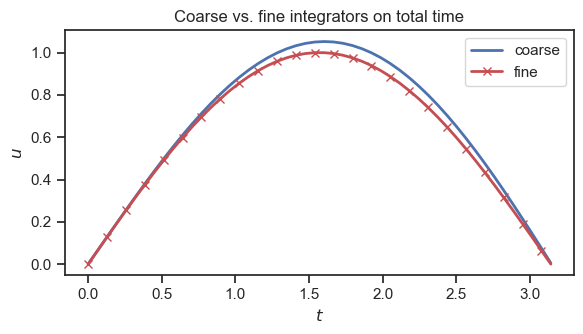

In [164]:
T = jnp.pi                  ## Total simulation time
u0 = jnp.array([0., 1.])    ## Initial state
RES = 50                    ## number of time points for plotting, n_steps

t, u_tilde = coarse_integrator(T, u0, n_steps=RES)
ax = plot(t, u_tilde[:, 0], label="coarse")

t, u_hat = fine_integrator(T, u0, n_steps=RES)
plot(t, u_hat[:, 0], "rx-", ax=ax, markevery=RES//20, label="fine", x_label=r"$t$", y_label=r"$u$", title="Coarse vs. fine integrators on total time");

Test the fine integrator as multiple initial value problems sequentially.

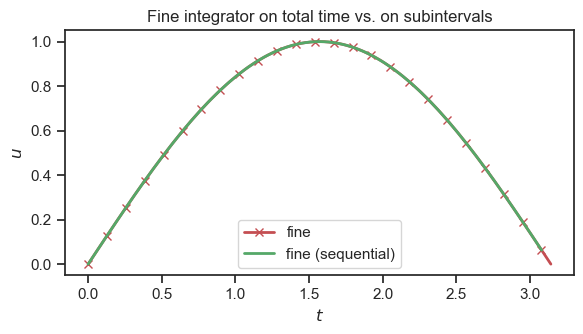

In [165]:
N = 10      ## number of processors, number of sequential steps
DT = T/N    ## Duration of the fine integrator, \Delta T

u_ = u0[jnp.newaxis, :]
t_ = jnp.array([0.0])
t_seq = []
u_hat_seq = []
for n in range(N):
    t_, u_ = fine_integrator(DT, u_[-1, :], n_steps=1+RES//N, t_s=t_[-1])
    u_hat_seq.append(u_[:-1, :])
    t_seq.append(t_[:-1])

t, u_hat = fine_integrator(T, u0, n_steps=RES)
ax = plot(t, u_hat[:, 0], "rx-", markevery=RES//20, label="fine", x_label=r"$t$", y_label=r"$u$")

t_seq = jnp.concatenate(t_seq)
u_hat_seq = jnp.concatenate(u_hat_seq)
ax = plot(t_seq, u_hat_seq[:, 0], "g-", label="fine (sequential)", ax=ax, title="Fine integrator on total time vs. on subintervals");
# print('shapes:', u_hat_seq.shape, u_hat.shape)

## Parareal algorithm

See [Feasibility study of the parareal algorithm](https://www2.imm.dtu.dk/pubdb/edoc/imm6482.pdf), page 12 (although that algorithm does not clearly state the solutions inside the $\Delta T$ subintervals).

In [166]:
K_max = 10           ## Maximum number of parareal iterations: 1 is ideal !
d = u0.shape[0]     ## Dimension of the problem

U_tilde = np.zeros((N, 1+RES//N, d))           ## Coarse solutions stacked
U_hat = np.zeros((N, 1+RES//N, d))             ## Fine solutions stacked
U = np.zeros((N, 1+RES//N, d))                 ## Corrected solution
T_tilde = np.zeros((N, 1+RES//N))       
T_hat = np.zeros((N, 1+RES//N))                 ## Should be the same as T_tilde

## Initial prediction
T_tilde[0, :], U_tilde[0, :, :] = coarse_integrator(DT, u0, n_steps=1+RES//N, t_s=0.0)
U[0, :, :] = U_tilde[0, :, :]
for n in range(1, N):
    T_tilde[n, :], U_tilde[n, :, :] = coarse_integrator(DT, U_tilde[n-1, -1], n_steps=1+RES//N, t_s=T_tilde[n-1, -1])
    U[n, :, :] = U_tilde[n, :, :]

for i in range(K_max):
    ## Parallel step
    T_hat[0, :], U_hat[0, :, :] = fine_integrator(DT, u0, n_steps=1+RES//N, get_sol=True, t_s=0.0)
    ##### Little hack to start at 0 and actually compute values
    U_tilde[-1, -1] = u0
    T_tilde[-1, -1] = 0.0
    #####
    for n in range(0, N):       ## Pay attention, loop starts at 1 in the original algorithm
        T_hat[n, :], U_hat[n, :, :] = fine_integrator(DT, U_tilde[n-1, -1], n_steps=1+RES//N, t_s=T_tilde[n-1, -1])

    ## Sequential step !
    # T_tilde[0, :], U[0, :, :] = coarse_integrator(DT, u0, n_steps=1+RES//N, get_sol=True, t_s=0.0)
    U[-1, -1] = u0   ##### Little hack to start at 0 !
    for n in range(0, N):   ## Original algorithm starts at 1
        U_tilde_old = U_tilde[n, :, :]      ## So smart how u_tilde for the next time step is computed at the same time !
        U_old = U[n, :, :]

        T_tilde[n, :], U_tilde[n, :, :] = coarse_integrator(DT, U[n-1, -1], n_steps=1+RES//N, t_s=T_tilde[n-1, -1])        ## Prediction
        U[n, :, :] = U_tilde[n, :, :] + (U_hat[n, :, :] - U_tilde_old)                                                                    ## Correction

    # if np.linalg.norm(U[n, :, :] - U_old) < 1e-22:        ## not working for now ...
    #     break

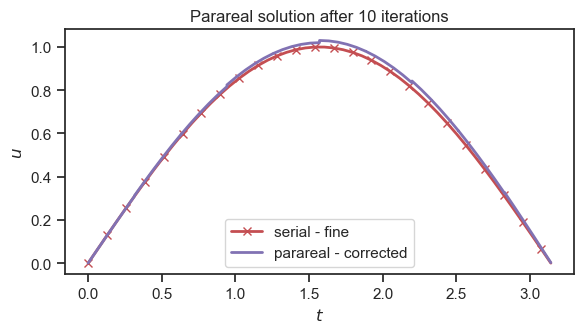

In [167]:
t_tilde = T_tilde.flatten()         ## The final column is repeated, but it doesn't matter. on the contrary, it helps detect the time subinterval boundaries !
t_hat = T_hat.flatten()
u_parareal_coarse = np.reshape(U_tilde, (-1, 2))
u_parareal_fine = np.reshape(U_hat, (-1, 2))
u_parareal = np.reshape(U, (-1, 2))

t_pure, u_pure = fine_integrator(T, u0, n_steps=RES)
ax = plot(t_pure, u_pure[:, 0], "rx-", markevery=RES//20, label="serial - fine")

# plot(t_tilde, u_parareal_coarse[:, 0], "bo", markevery=RES//20, ax=ax, label="parareal - coarse")
# plot(t_hat, u_parareal_fine[:, 0], "g>", markevery=RES//20, ax=ax, label="parareal - fine")
plot(t_hat, u_parareal[:, 0], "m-", label="parareal - corrected", ax=ax, x_label=r"$t$", y_label=r"$u$", title="Parareal solution after "+str(K_max)+" iterations");

## Findings
- We started our processors loops `for n in range(1, N)` at `0` because this is not pseudo-code. A little hack/trick was needed to be done to ensure the loop runs
- The stop condition is not working. The norm `np.linalg.norm(U[n, :, :] - U_old)` keeps falling to exactly `0`
- The high number of iterations doesn't seems to fix the final precision error (see the plot) ! WHY ? 
    - Because the resolution is low !! change `RES` from `100` to `1000` to see the difference. 
    - This indicates that the accuracy of the method is governed by the coarse propagator (remember that for the fine propagator, we used `solve_ivp`, i.e. we have no control on it's resolution)
- Try implementing Parareal using Jax, not Numpy. (Find an efficient way to update arrays, or store them at the very least.)
- We did not perform a performance study; but PyOMP could be used for the parallel step ...